跑一个 cifar-10 的 demo 看看

先把 cifar-10 的数据引入进来

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision.models as models
import torch.nn as nn

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# dir(os.environ)

use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

定义数据集

In [4]:
transform = transforms.Compose(
    [
#         transforms.RandomSizedCrop(224),
        transforms.RandomCrop(32, padding=2),
        transforms.RandomHorizontalFlip(),
#         transforms.Scale(244),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

出几张图看一看

 bird   cat truck  deer  frog   cat  ship  deer


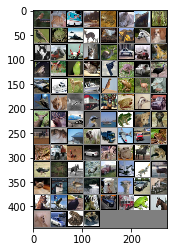

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

定义 net

In [20]:

net = models.alexnet(num_classes=10)
# net = models.vgg11()
# net = models.resnet18()
# net = models.densenet121()

# net = net.cuda()
# net = nn.DataParallel(net).cuda()

net AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


LeNet

In [13]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


AlexNet

In [24]:

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 32 * 6 * 6)
        x = self.classifier(x)
        return x

net = AlexNet(num_classes=10)

In [25]:
if use_cuda:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

# 加载之前的参数
# net.load_state_dict( torch.load('../net_state/resnet18_cifar10_epoch30_params.pkl') )

print('net', net)

net DataParallel (
  (module): AlexNet (
    (features): Sequential (
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
      (1): ReLU (inplace)
      (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU (inplace)
      (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU (inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU (inplace)
      (10): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU (inplace)
      (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    )
    (classifier): Sequential (
      (0): Dropout (p = 0.5)
      (1): Linear (1152 -> 4096)
      (2): ReLU (inplace)
      (3): Dropout (p = 0.5)
      (4): Linear (4096 -> 4096)
      (5): ReLU (in

定义一个损失函数，调整学习率

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

定义训练和测试函数

In [1]:
import time

def train(epoch):
    print('\nEpoch: %d' % epoch)
    t1 = time.time()
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # get the inputs
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # wrap them in Variable
        inputs, targets = Variable(inputs), Variable(targets)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('m-b %4d loss: %.3f | Acc: %.3f%% | lr: %.4f | time: %.2f' %
                ( batch_idx+1, train_loss/batch_idx+1, 100.*correct/total, optimizer.param_groups[0]['lr'], time.time() - t1 ) )
            
def eval(epoch):
    global best_acc
    net.eval()
    t1 = time.time()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

#         if batch_idx % 100 == 99:    # print every 100 mini-batches
    print('test loss: %.3f | Acc: %.3f%% | lr: %.4f | time: %.2f' %
        ( test_loss/batch_idx+1, 100.*correct/total, optimizer.param_groups[0]['lr'], time.time() - t1 ) )
        # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if use_cuda else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return test_loss / len(testloader)


Test the network on the test data

In [28]:
for epoch in range(start_epoch, start_epoch + 10):
    train(epoch)
    val_loss = eval(epoch)
    scheduler.step(val_loss)


Epoch: 0


RuntimeError: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small at /pytorch/torch/lib/THCUNN/generic/SpatialDilatedMaxPooling.cu:69

把参数保存起来

In [11]:
torch.save(net.state_dict(), '../net_state/resnet18_cifar10_epoch70_params.pkl')